### Image processing

In [1]:
import imageio
import os
import pydot
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

2024-06-08 19:27:52.253123: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 19:27:56.525926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def preprocess_imagery(path):
    '''
    Pre process satellite imagery. We check for nans in the composite images,
    and then we load them into the [0,1] range.
    Input: TIF files downloaded from GEE (224x224x7)
    '''
    #reading image
    path=str(path).strip('b').strip("'")
    image=imageio.imread(path)
    if np.sum(np.isnan(image))>0:
        #print(str(np.sum(np.isnan(image)))+"nans found")
        #taking the mean of the image, per channel
        mean=np.nanmean(image,axis=(0,1))
        #replacing NaN with per channel mean
        replacement=np.isnan(image)*mean
        image[np.isnan(image)]=replacement[np.isnan(image)]  
        #print(str(np.sum(np.isnan(image)))+"nans found")
        nan_channels = np.all(np.isnan(image), axis=(0, 1))
        # Replacing NaN with 0 where all values in a channel are NaN
        image[:, :, nan_channels] = np.nan_to_num(image[:, :, nan_channels])
        image=image/255
    return image

In [3]:
image_files = [f for f in os.listdir("../GEE_Images")]
image_files=image_files
len(image_files)

51782

In [9]:
#run when mp10.txt not present
image_info=[]
for image in image_files:
    name,_=os.path.splitext(image)
    image_info.append(['_'.join(name.split(' ')[0].split('_')[:-1]),name.split(' ')[0].split('_')[-1]])
df=pd.read_csv('processed_data.csv')
mp10_0=[]
mp10_1=[]
mp10_2=[]
a=0
image_files_0=[]
image_files_1=[]
image_files_2=[]
for info in image_info:
    value=(df[(df['station']==info[0]) & (df['Date']==info[1])])
    if value['region'].values[0]==0:
        mp10_0.append(value['mp10'].values[0])
        image_files_0.append(image_files[a])
        
    elif value['region'].values[0]==1:
        mp10_1.append(value['mp10'].values[0])
        image_files_1.append(image_files[a])
        
    else:
        mp10_2.append(value['mp10'].values[0])
        image_files_2.append(image_files[a])
    a+=1


In [10]:
with open("mp10_0.txt", "w") as f:
  for value in mp10_0:
    f.write(str(value) + "\n")
with open("mp10_1.txt", "w") as f:
  for value in mp10_1:
    f.write(str(value) + "\n")
with open("mp10_2.txt", "w") as f:
  for value in mp10_2:
    f.write(str(value) + "\n")
with open("image_list_0.txt", "w") as f:
  for value in image_files_0:
    f.write(str(value) + "\n")
with open("image_list_1.txt", "w") as f:
  for value in image_files_1:
    f.write(str(value) + "\n")
with open("image_list_2.txt", "w") as f:
  for value in image_files_2:
    f.write(str(value) + "\n")

In [3]:
with open('mp10_0.txt', 'r') as f:
  mp10 = [float(line.strip()) for line in f]
mp10=np.array(mp10)

In [4]:
with open('image_list_0.txt', 'r') as f:
  image_files = [str(line.strip()) for line in f]


In [5]:
#min max scaling
min_val = np.min(mp10)
max_val = np.max(mp10)
mp10 = (mp10 - min_val) / (max_val - min_val)

In [6]:

for a in range(len(image_files)):
    image_files[a]="/home/benjaxmen/Downloads/GEE_Images/"+image_files[a]
train_image_files, test_image_files, train_mp10, test_mp10 = train_test_split(
    image_files, mp10, test_size=0.2, random_state=42)


In [7]:
len(image_files)

13616

In [7]:
test_mp10=np.array(test_mp10)

### Model using one NN 224,224,6 

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape):
    model = models.Sequential()

    # Capa convolucional
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    # Capa de pooling
    model.add(layers.AveragePooling2D((2, 2)))

    # Otras capas convolucionales y de pooling para aumentar la profundidad
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    # Aplanar los datos para alimentar la capa densa
    model.add(layers.Flatten())

    # Capas densas para la parte final de la red
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularización con dropout
    model.add(layers.Dense(1, activation='linear'))  # Capa de salida con activación lineal para valores float

    return model

# Crear el modelo
input_shape = (224, 224, 6)
model = build_model(input_shape)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mse'])

# Resumen del modelo
model.summary()


/home/benjaxmen/miniconda3/envs/ee/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 111, 111, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 54, 54, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 26, 26, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 12, 12, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 614,097 (2.34 MB)

 Trainable params: 614,097 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

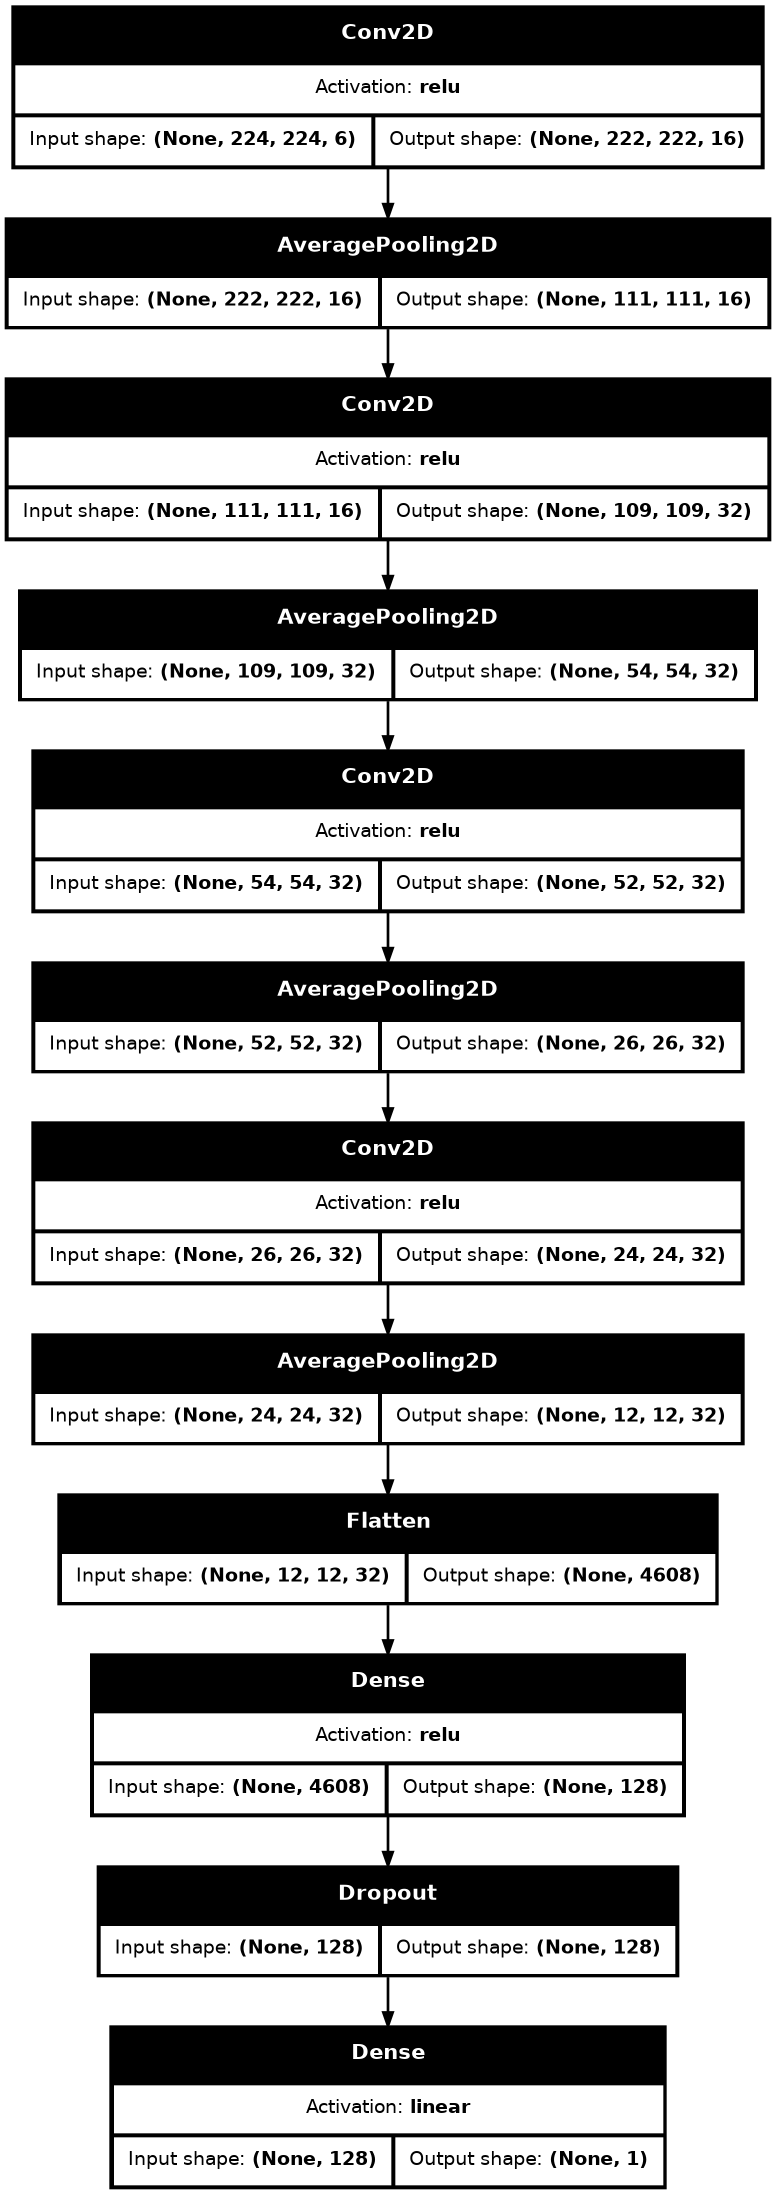

In [67]:
from keras.utils import plot_model
# Just showing all possible argument for newcomer.  
tf.keras.utils.plot_model(
    model,                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=False,  # show shapes and layer name
    expand_nested=False, show_layer_activations=True                      # will show nested block
)

In [19]:
batch_size = 5000
epochs = 15
full_history=[]
num_parts = len(image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor((preprocess_imagery(imgs)),dtype=tf.float32))
    images=np.array(images)
    history=model.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True,validation_split=0.2)
    full_history.append([history.history['loss'],history.history['val_loss'],history.history['mse'],history.history['val_mse']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = np.array(mp10[num_parts * batch_size:])
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor((preprocess_imagery(imgs)),dtype=tf.float32))
    images=np.array(images)
    history=model.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True,validation_split=0.2)
    full_history.append([history.history['loss'],history.history['val_loss'],history.history['mse'],history.history['val_mse']])

Part:  1


/tmp/ipykernel_2960/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_2960/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15


2024-06-08 20:44:24.551126: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4816896000 exceeds 10% of free system memory.


80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 384ms/step - loss: 1150.1044 - mse: 23065184.0000 - val_loss: 0.0104 - val_mse: 1.6182e-04
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 384ms/step - loss: 0.0229 - mse: 0.0130 - val_loss: 0.0106 - val_mse: 1.7258e-04
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 384ms/step - loss: 0.0166 - mse: 4.5449e-04 - val_loss: 0.0106 - val_mse: 1.7487e-04
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 385ms/step - loss: 0.0172 - mse: 4.8030e-04 - val_loss: 0.0106 - val_mse: 1.7236e-04
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - loss: 0.0169 - mse: 4.8793e-04 - val_loss: 0.0111 - val_mse: 1.9060e-04
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - loss: 0.0169 - mse: 4.8063e-04 - val_loss: 0.0105 - val_mse: 1.7154e-04
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - loss: 0.0165 - mse: 4.3563e-04 - val_loss: 0.0107 - val_mse: 1.7608e-04
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - loss: 0.0165 - mse: 4.5934e-04 - val_loss: 0.0105 - val_mse: 1.68

2024-06-08 21:08:17.145313: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4816896000 exceeds 10% of free system memory.


80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 384ms/step - loss: 0.0125 - mse: 4.5463e-04 - val_loss: 0.0193 - val_mse: 6.8142e-04
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 383ms/step - loss: 0.0133 - mse: 4.9624e-04 - val_loss: 0.0193 - val_mse: 6.8870e-04
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 385ms/step - loss: 0.0136 - mse: 5.5201e-04 - val_loss: 0.0193 - val_mse: 6.8055e-04
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - loss: 0.0132 - mse: 5.5302e-04 - val_loss: 0.0189 - val_mse: 6.5329e-04
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 387ms/step - loss: 0.4114 - mse: 469.9008 - val_loss: 0.0194 - val_mse: 7.1374e-04
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 387ms/step - loss: 0.0136 - mse: 5.2521e-04 - val_loss: 0.0194 - val_mse: 7.1931e-04
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 387ms/step - loss: 0.0133 - mse: 5.0211e-04 - val_loss: 0.0194 - val_mse: 7.1281e-04
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - loss: 0.0131 - mse: 5.2287e-04 - val_loss: 0.0194 - val_mse: 7.1138e-

In [71]:
s=[np.std(mp10)]*15

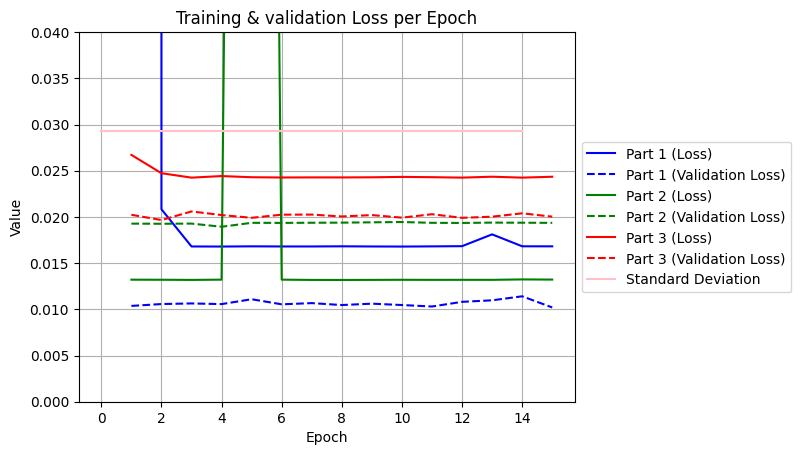

In [78]:
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

# Itera sobre cada full_history y grafica sus datos

for a in range(len(full_history)):
    # Extrae los valores de loss y mae de la full_history actual
    loss = full_history[a][0]
    mae = full_history[a][1]
    
    # Grafica los valores de loss
    plt.plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
    
    
    # Grafica los valores de mae
    plt.plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (Validation Loss)', linestyle='dashed', color=colors[a])
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.04)
plt.title('Training & validation Loss per Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.grid(True)
plt.savefig('val_loss_whole.png',format='png')
# Muestra el gráfico
plt.show()


### For 6 NN with 224,224

In [27]:

def separar_imagen(imagen):
    """
    Separa una imagen con dimensiones (224, 224, 6) en 6 imágenes con dimensiones (224, 224, 1).

    Args:
    imagen (numpy.ndarray): Imagen original con dimensiones (224, 224, 6).

    Returns:
    tuple: Una tupla con 6 numpy.ndarrays, cada uno con dimensiones (224, 224, 1).
    """
    # Verificar que la imagen tenga las dimensiones correctas
    assert imagen.shape == (224, 224, 6), "La imagen debe tener dimensiones (224, 224, 6)"
    
    # Separar la imagen en 6 partes
    imagenes_separadas = tuple(imagen[:, :, i][:, :, np.newaxis] for i in range(6))
    
    return imagenes_separadas

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout

def build_model_layer():
    # Crear el modelo secuencial
    model = Sequential()

    # Añadir la capa de convolución 2D
    model.add(Conv2D(filters=8, kernel_size=(1, 1), activation='relu', input_shape=(224, 224, 1)))

    # Añadir la capa de Average Pooling
    model.add(AveragePooling2D(pool_size=(2, 2)))
    # Añadir la capa de convolución 2D
    model.add(Conv2D(filters=8, kernel_size=(1, 1), activation='relu', input_shape=(224, 224, 1)))

    # Añadir la capa de Average Pooling
    model.add(AveragePooling2D(pool_size=(2, 2)))
    # Añadir la capa de convolución 2D
    model.add(Conv2D(filters=8, kernel_size=(1,1), activation='relu', input_shape=(224, 224, 1)))

    # Añadir la capa de Average Pooling
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Aplanar la salida de la capa de pooling
    model.add(Flatten())

    # Añadir una capa densa
    model.add(Dense(units=128, activation='relu'))

    # Añadir la capa de Dropout
    model.add(Dropout(rate=0.5))

    # Añadir la capa de salida con activación lineal
    model.add(Dense(units=1, activation='linear'))
    return model

#### Global settings for the layered models

In [30]:
epochs = 15

#### Model for layer 0

In [31]:
model_0=build_model_layer()
# Compilar el modelo
model_0.compile(optimizer='adam', loss='mean_absolute_error')

# Resumen del modelo
model_0.summary()

/home/benjaxmen/miniconda3/envs/ee/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 8)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 112, 112, 8)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 8)    │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 56, 56, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 28, 28, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,233 (3.06 MB)

 Trainable params: 803,233 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:

images=[]
for imgs in image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[0],dtype=tf.float32))
images=np.array(images)
history_0=model_0.fit(images,mp10,epochs=15,batch_size=50,shuffle=True,validation_split=0.2)


/tmp/ipykernel_2960/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_2960/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 322.4435 - val_loss: 0.0269
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0158 - val_loss: 0.0270
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0157 - val_loss: 0.0268
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0159 - val_loss: 0.0269
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0157 - val_loss: 0.0269
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0157 - val_loss: 0.0270
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0158 - val_loss: 0.0270
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0157 - val_loss: 0.0268
Epoch 9/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0158 - val_loss: 0.0268
Epoch 10/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0157 - val_loss: 0.0268
Epoch 11/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0158 - val_loss: 0.0267
Epoch 12/15
218/218 ━━━━━━━━

#### Model for layer 1

In [34]:
model_1=build_model_layer()
# Compilar el modelo
model_1.compile(optimizer='adam', loss='mean_absolute_error')

/home/benjaxmen/miniconda3/envs/ee/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
images=[]
for imgs in image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[1],dtype=tf.float32))
images=np.array(images)
history_1=model_1.fit(images,mp10,epochs=15,batch_size=50,shuffle=True,validation_split=0.2)


/tmp/ipykernel_2960/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_2960/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 129.9447 - val_loss: 0.0269
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0158 - val_loss: 0.0267
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0158 - val_loss: 0.0266
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0160 - val_loss: 0.0269
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0158 - val_loss: 0.0268
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0159 - val_loss: 0.0267
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0161 - val_loss: 0.0267
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0160 - val_loss: 0.0268
Epoch 9/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0156 - val_loss: 0.0267
Epoch 10/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0159 - val_loss: 0.0267
Epoch 11/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0158 - val_loss: 0.0269
Epoch 12/15
218/218 ━━━━━━━━

#### Model for layer 2

In [36]:
model_2=build_model_layer()
# Compilar el modelo
model_2.compile(optimizer='adam', loss='mean_absolute_error')

In [37]:
images=[]
for imgs in image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[2],dtype=tf.float32))
images=np.array(images)
history_2=model_2.fit(images,mp10,epochs=15,batch_size=50,shuffle=True,validation_split=0.2)

/tmp/ipykernel_2960/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_2960/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 230.9155 - val_loss: 0.0267
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0161 - val_loss: 0.0268
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0158 - val_loss: 0.0267
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0156 - val_loss: 0.0267
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0159 - val_loss: 0.0267
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0157 - val_loss: 0.0269
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0157 - val_loss: 0.0267
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0159 - val_loss: 0.0267
Epoch 9/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0158 - val_loss: 0.0267
Epoch 10/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0160 - val_loss: 0.0269
Epoch 11/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0159 - val_loss: 0.0268
Epoch 12/15
218/218 ━━━━━━━━

#### Model for layer 3

In [38]:
model_3=build_model_layer()
# Compilar el modelo
model_3.compile(optimizer='adam', loss='mean_absolute_error')

In [39]:
images=[]
for imgs in image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[3],dtype=tf.float32))
images=np.array(images)
history_3=model_3.fit(images,mp10,epochs=15,batch_size=50,shuffle=True,validation_split=0.2)

/tmp/ipykernel_2960/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_2960/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 1006.6731 - val_loss: 0.0275
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0158 - val_loss: 0.0275
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0159 - val_loss: 0.0275
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0159 - val_loss: 0.0275
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0158 - val_loss: 0.0276
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0159 - val_loss: 0.0275
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0160 - val_loss: 0.0276
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0160 - val_loss: 0.0275
Epoch 9/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0161 - val_loss: 0.0274
Epoch 10/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0161 - val_loss: 0.0275
Epoch 11/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0161 - val_loss: 0.0276
Epoch 12/15
218/218 ━━━━━━━

#### Model for layer 4

In [40]:
model_4=build_model_layer()
# Compilar el modelo
model_4.compile(optimizer='adam', loss='mean_absolute_error')

In [41]:
images=[]
for imgs in image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[4],dtype=tf.float32))
images=np.array(images)
history_4=model_4.fit(images,mp10,epochs=15,batch_size=50,shuffle=True,validation_split=0.2)

/tmp/ipykernel_2960/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_2960/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 1105.1930 - val_loss: 0.0268
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0159 - val_loss: 0.0263
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0161 - val_loss: 0.0265
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0156 - val_loss: 0.0266
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - loss: 0.0158 - val_loss: 0.0270
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0162 - val_loss: 0.0264
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0157 - val_loss: 0.0265
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0158 - val_loss: 0.0267
Epoch 9/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 2.4234 - val_loss: 0.0269
Epoch 10/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0162 - val_loss: 0.0266
Epoch 11/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 0.0160 - val_loss: 0.0265
Epoch 12/15
218/218 ━━━━━

#### Model for layer 5

In [42]:
model_5=build_model_layer()
# Compilar el modelo
model_5.compile(optimizer='adam', loss='mean_absolute_error')


/home/benjaxmen/miniconda3/envs/ee/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/benjaxmen/miniconda3/envs/ee/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
images=[]
for imgs in image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[5],dtype=tf.float32))
images=np.array(images)
history_5=model_5.fit(images,mp10,epochs=15,batch_size=50,shuffle=True,validation_split=0.2)

/tmp/ipykernel_2960/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_2960/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 1655.0052 - val_loss: 0.0262
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0160 - val_loss: 0.0267
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0158 - val_loss: 0.0262
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0158 - val_loss: 0.0268
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0159 - val_loss: 0.0269
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0158 - val_loss: 0.0273
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0160 - val_loss: 0.0269
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0160 - val_loss: 0.0267
Epoch 9/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0160 - val_loss: 0.0271
Epoch 10/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - loss: 0.0161 - val_loss: 0.0268
Epoch 11/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0161 - val_loss: 0.0268
Epoch 12/15
218/218 ━━━━━━━

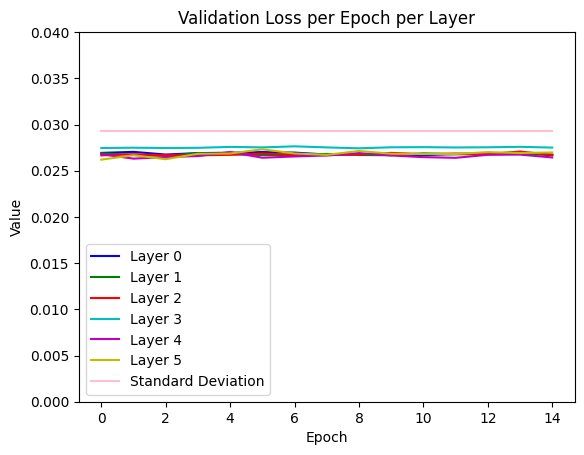

In [83]:
import matplotlib.pyplot as plt
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']
plt.plot(history_0.history['val_loss'], label='Layer 0', color=colors[0])
plt.plot(history_1.history['val_loss'], label='Layer 1', color=colors[1])
plt.plot(history_2.history['val_loss'], label='Layer 2', color=colors[2])
plt.plot(history_3.history['val_loss'], label='Layer 3', color=colors[3])
plt.plot(history_4.history['val_loss'], label='Layer 4', color=colors[4])
plt.plot(history_5.history['val_loss'], label='Layer 5', color=colors[5])
plt.plot(s,label='Standard Deviation',color='pink')
plt.ylim(0,0.04)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Loss per Epoch per Layer')
plt.legend()
plt.savefig('val_loss_layered-comp.png',format='png')
plt.show()

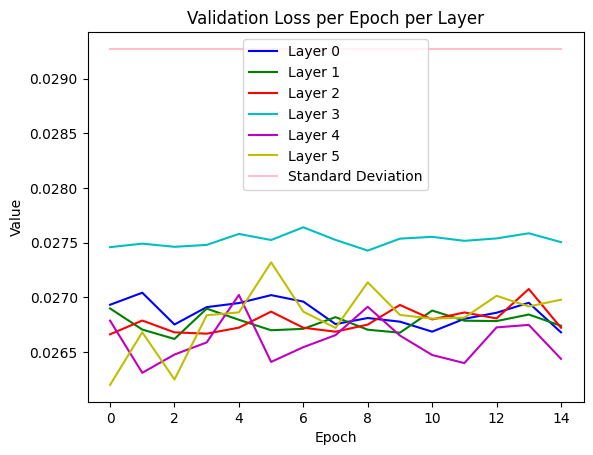

In [84]:
import matplotlib.pyplot as plt
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']
plt.plot(history_0.history['val_loss'], label='Layer 0', color=colors[0])
plt.plot(history_1.history['val_loss'], label='Layer 1', color=colors[1])
plt.plot(history_2.history['val_loss'], label='Layer 2', color=colors[2])
plt.plot(history_3.history['val_loss'], label='Layer 3', color=colors[3])
plt.plot(history_4.history['val_loss'], label='Layer 4', color=colors[4])
plt.plot(history_5.history['val_loss'], label='Layer 5', color=colors[5])
plt.plot()
plt.plot(s,label='Standard Deviation',color='pink')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Loss per Epoch per Layer')
plt.legend()
plt.savefig('val_loss_layered.png',format='png')
plt.show()

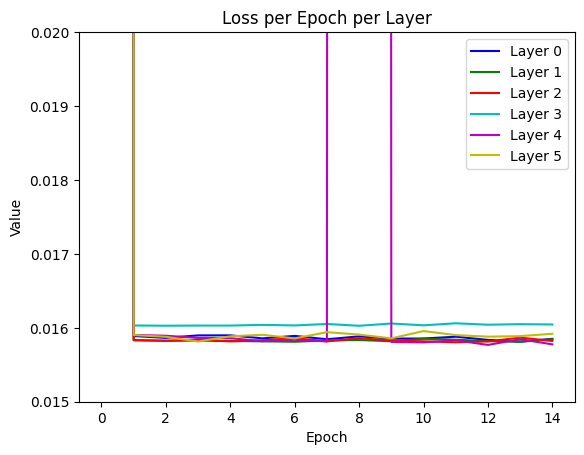

In [62]:
import matplotlib.pyplot as plt
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']
plt.plot(history_0.history['loss'], label='Layer 0', color=colors[0])
plt.plot(history_1.history['loss'], label='Layer 1', color=colors[1])
plt.plot(history_2.history['loss'], label='Layer 2', color=colors[2])
plt.plot(history_3.history['loss'], label='Layer 3', color=colors[3])
plt.plot(history_4.history['loss'], label='Layer 4', color=colors[4])
plt.plot(history_5.history['loss'], label='Layer 5', color=colors[5])
plt.xlabel('Epoch')
plt.ylim(0.015,0.02)
plt.ylabel('Value')
plt.title('Loss per Epoch per Layer')
plt.legend()
plt.savefig('loss_layered.png',format='png')
plt.show()

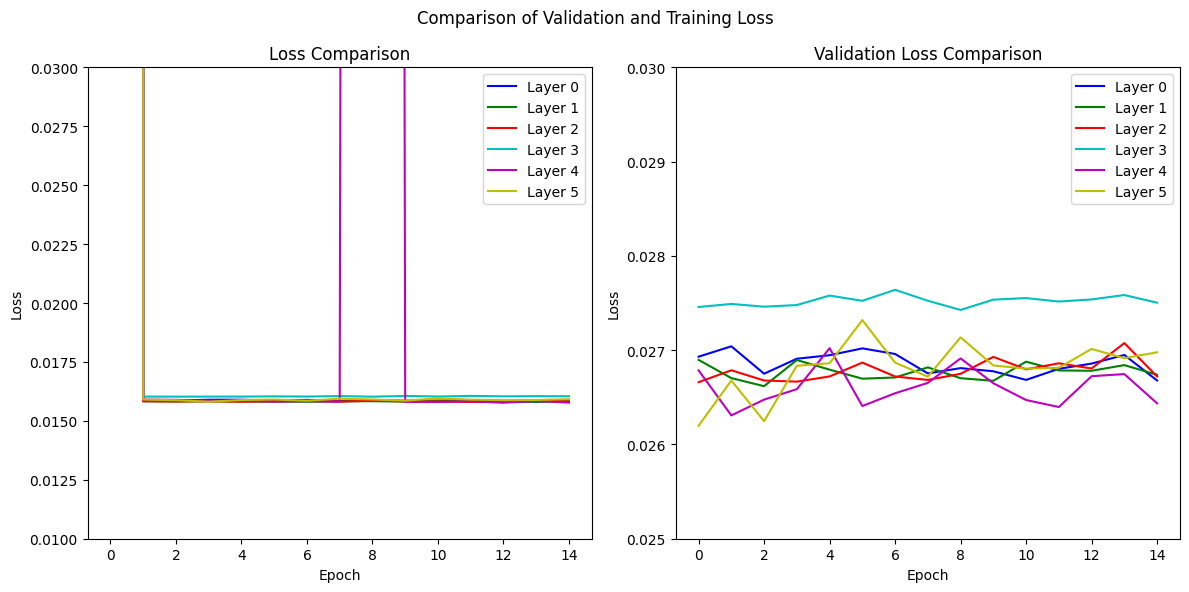

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history_0.history['loss'], label='Layer 0', color=colors[0])
ax1.plot(history_1.history['loss'], label='Layer 1', color=colors[1])
ax1.plot(history_2.history['loss'], label='Layer 2', color=colors[2])
ax1.plot(history_3.history['loss'], label='Layer 3', color=colors[3])
ax1.plot(history_4.history['loss'], label='Layer 4', color=colors[4])
ax1.plot(history_5.history['loss'], label='Layer 5', color=colors[5])
ax1.set_title('Loss Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(history_0.history['val_loss'], label='Layer 0', color=colors[0])
ax2.plot(history_1.history['val_loss'], label='Layer 1', color=colors[1])
ax2.plot(history_2.history['val_loss'], label='Layer 2', color=colors[2])
ax2.plot(history_3.history['val_loss'], label='Layer 3', color=colors[3])
ax2.plot(history_4.history['val_loss'], label='Layer 4', color=colors[4])
ax2.plot(history_5.history['val_loss'], label='Layer 5', color=colors[5])

ax1.set_title('Loss Comparison')
ax1.set_ylim(0.01,0.03)
ax2.set_ylim(0.025,0.03)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_title('Validation Loss Comparison')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
plt.suptitle('Comparison of Validation and Training Loss')
plt.tight_layout()
plt.savefig('loss & val.png',format='png')
plt.show()

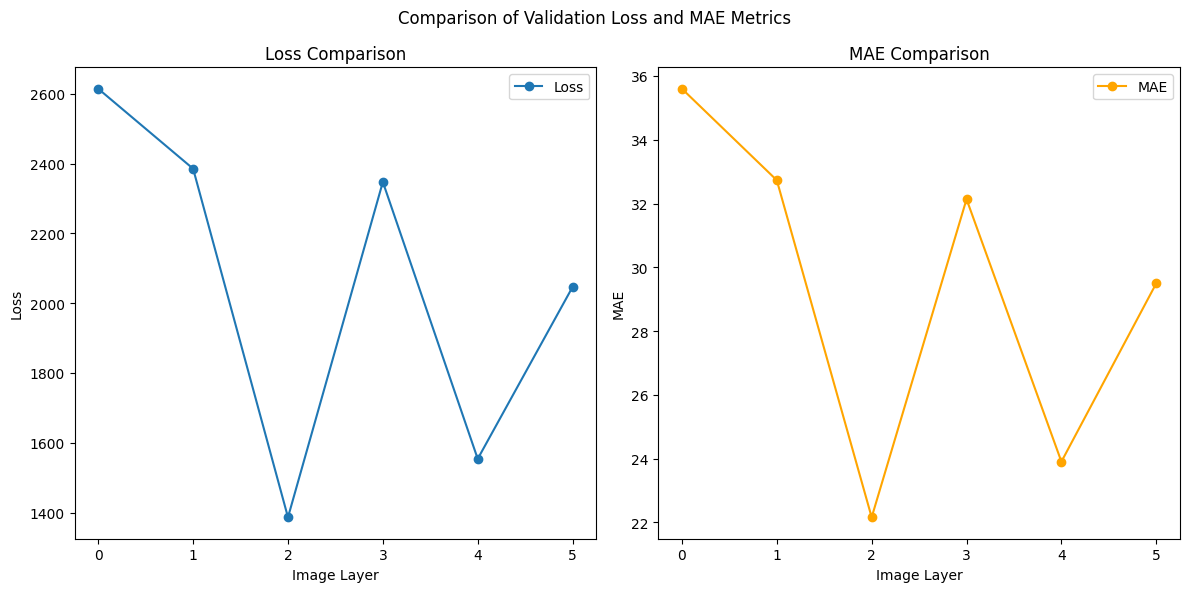

In [35]:
import matplotlib.pyplot as plt

# Assuming you have op_0 to op_5 arrays with loss and MAE values
# Replace these with your actual data

# Extract loss and MAE values
loss_values = [op[0] for op in [op_0, op_1, op_2, op_3, op_4, op_5]]
mae_values = [op[1] for op in [op_0, op_1, op_2, op_3, op_4, op_5]]

# Create subplots for loss and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss
ax1.plot(loss_values, marker='o', label='Loss')
ax1.set_title('Loss Comparison')
ax1.set_xlabel('Image Layer')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE
ax2.plot(mae_values, marker='o', color='orange', label='MAE')
ax2.set_title('MAE Comparison')
ax2.set_xlabel('Image Layer')
ax2.set_ylabel('MAE')
ax2.legend()
plt.suptitle('Comparison of Validation Loss and MAE Metrics')
plt.tight_layout()
plt.savefig('loss & mae val.png',format='png')
plt.show()



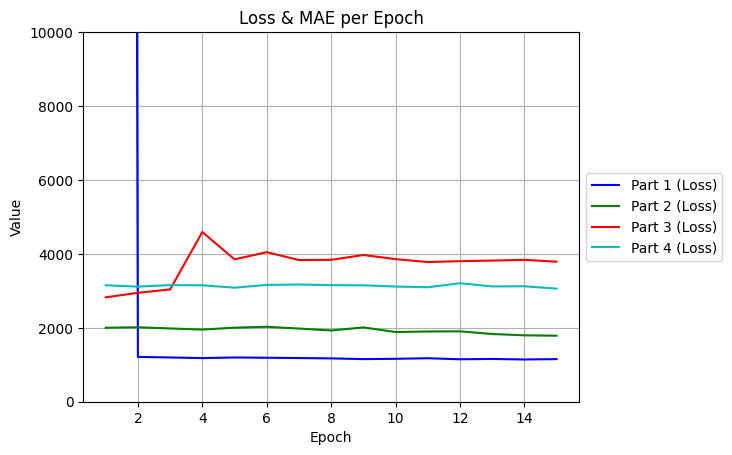

In [36]:
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

# Itera sobre cada full_history y grafica sus datos

for a in range(len(full_history_0)):
    # Extrae los valores de loss y mae de la full_history actual
    loss = full_history_0[a][0]
    mae = full_history_0[a][1]
    
    # Grafica los valores de loss
    plt.plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
    
    # Grafica los valores de mae
    #plt.plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (MAE)', linestyle='dashed', color=colors[a])

# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,10000)

plt.title('Loss & MAE per Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Coloca la leyenda fuera del gráfico
plt.grid(True)

# Muestra el gráfico
plt.show()


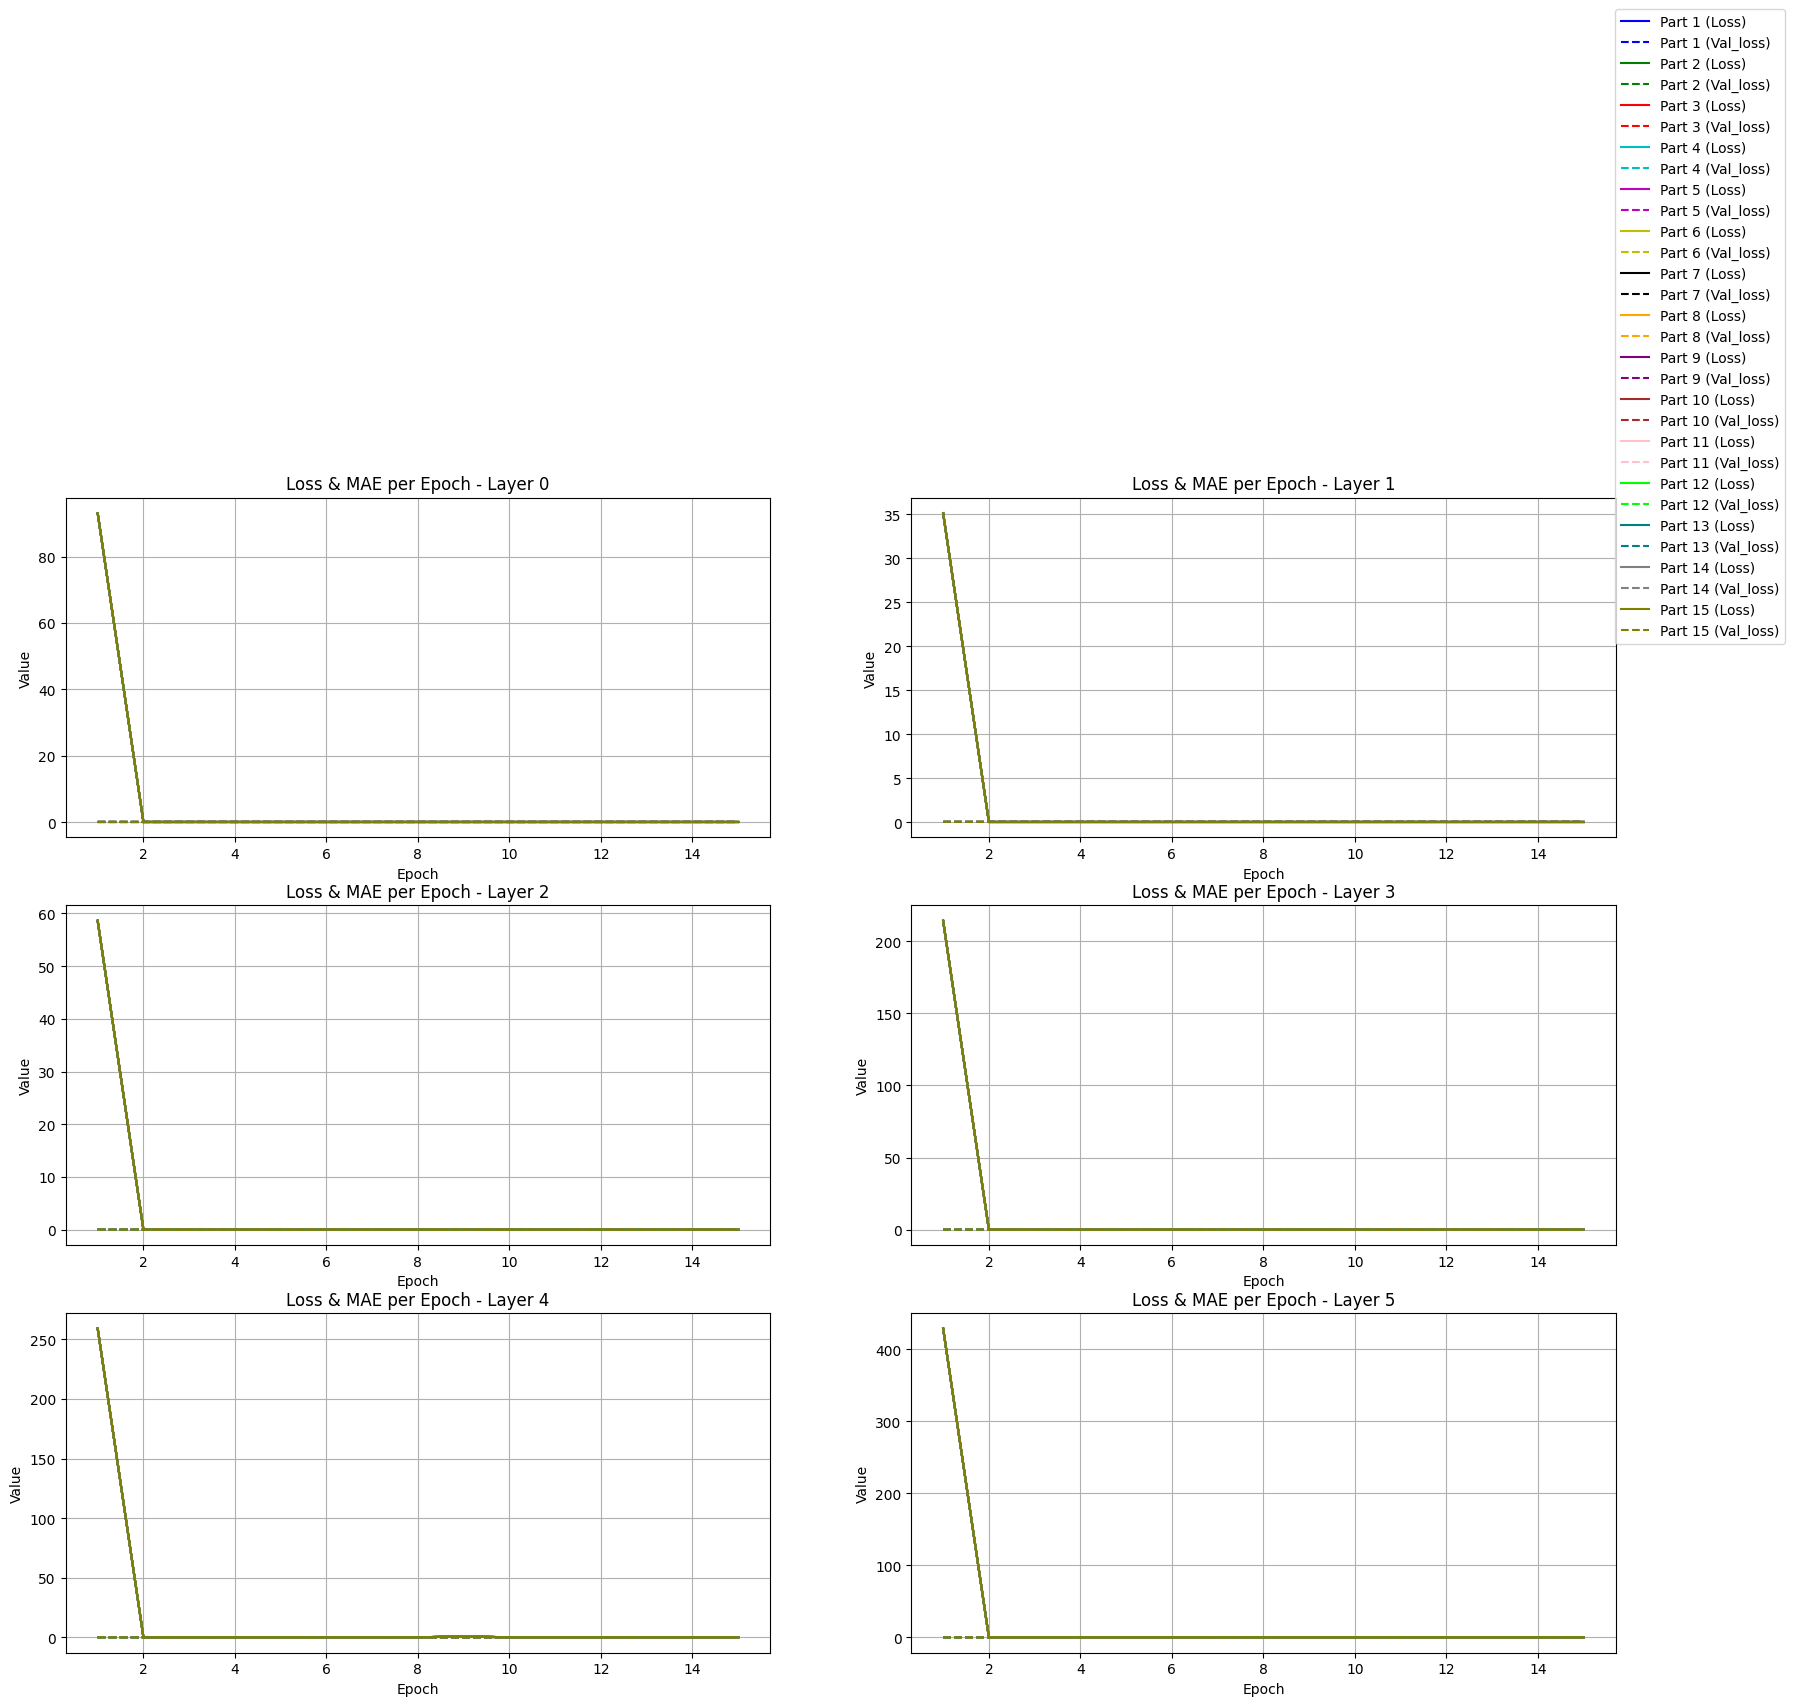

In [44]:
num_filas = 3
num_columnas = 2
full_histories=[history_0,history_1,history_2,history_3,history_4,history_5]
# Crea la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 15))
for i in range(num_filas):
    for j in range(num_columnas):
        index = i * num_columnas + j
        if index < len(full_histories):
            for a in range(len(full_histories[i*2+j].history['loss'])):
                # Extrae los valores de loss y mae de la full_history actual
                loss = full_histories[i*2+j].history['loss']
                val_loss = full_histories[i*2+j].history['val_loss']
                
                # Grafica los valores de loss
                axs[i,j].plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
                
                # Grafica los valores de mae
                axs[i,j].plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (Val_loss)', linestyle='dashed', color=colors[a])
                axs[i, j].set_xlabel('Epoch')
                axs[i, j].set_ylabel('Value')
                axs[i, j].set_title('Loss & MAE per Epoch - Layer {}'.format(index))
                
                axs[i, j].grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,2.95))
            
plt.savefig('loss & val_loss layered.png',format='png')

# Muestra la figura
plt.show()

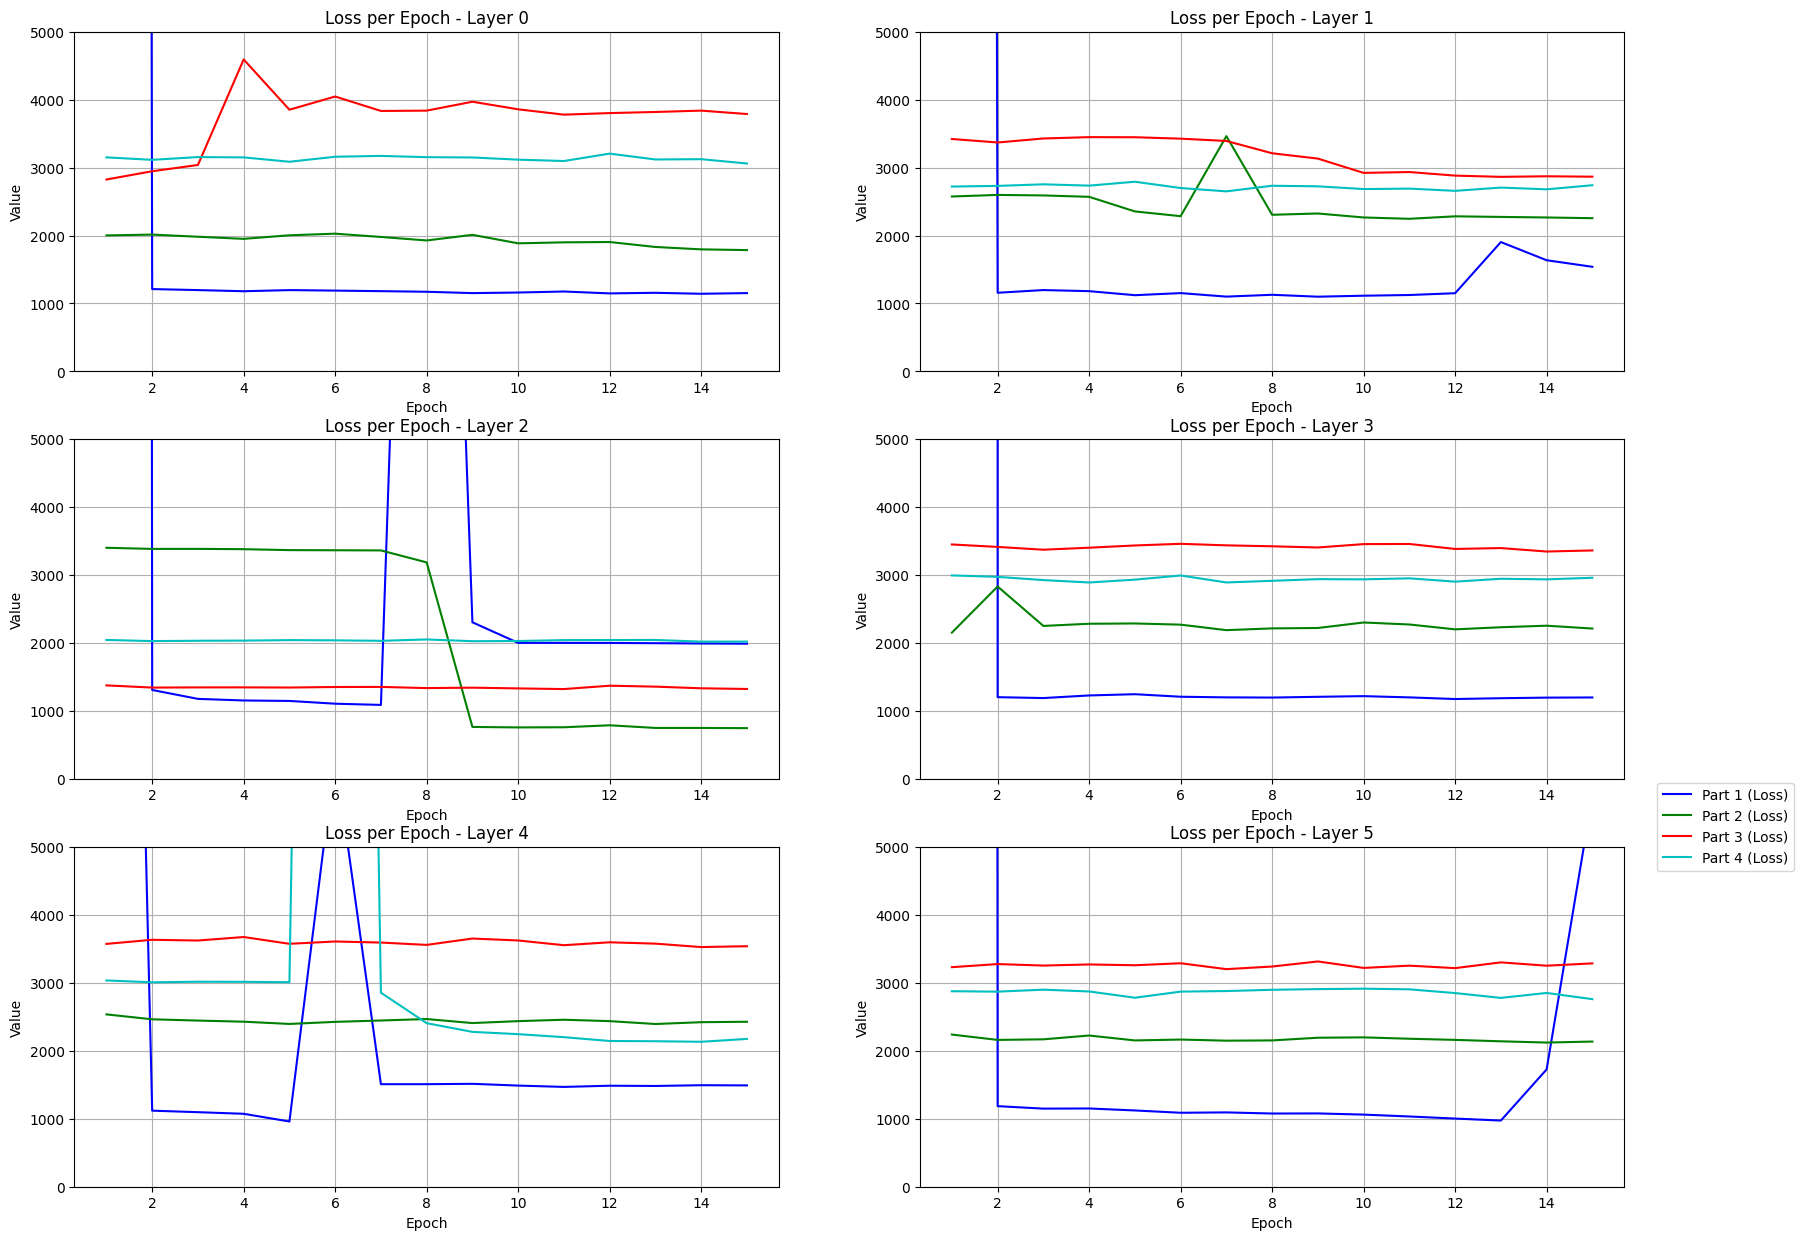

In [38]:
num_filas = 3
num_columnas = 2
full_histories=[full_history_0,full_history_1,full_history_2,full_history_3,full_history_4,full_history_5]
# Crea la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 15))
for i in range(num_filas):
    for j in range(num_columnas):
        index = i * num_columnas + j
        if index < len(full_histories):
            for a in range(len(full_histories[i*2+j])):
                # Extrae los valores de loss y mae de la full_history actual
                loss = full_histories[i*2+j][a][0]
                
                # Grafica los valores de loss
                axs[i,j].plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
                axs[i, j].set_xlabel('Epoch')
                axs[i, j].set_ylabel('Value')
                axs[i, j].set_ylim(0,5000)
                axs[i, j].set_title('Loss per Epoch - Layer {}'.format(index))
                
                axs[i, j].grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,0.91))
            

plt.savefig('loss layered.png',format='png')
# Muestra la figura
plt.show()

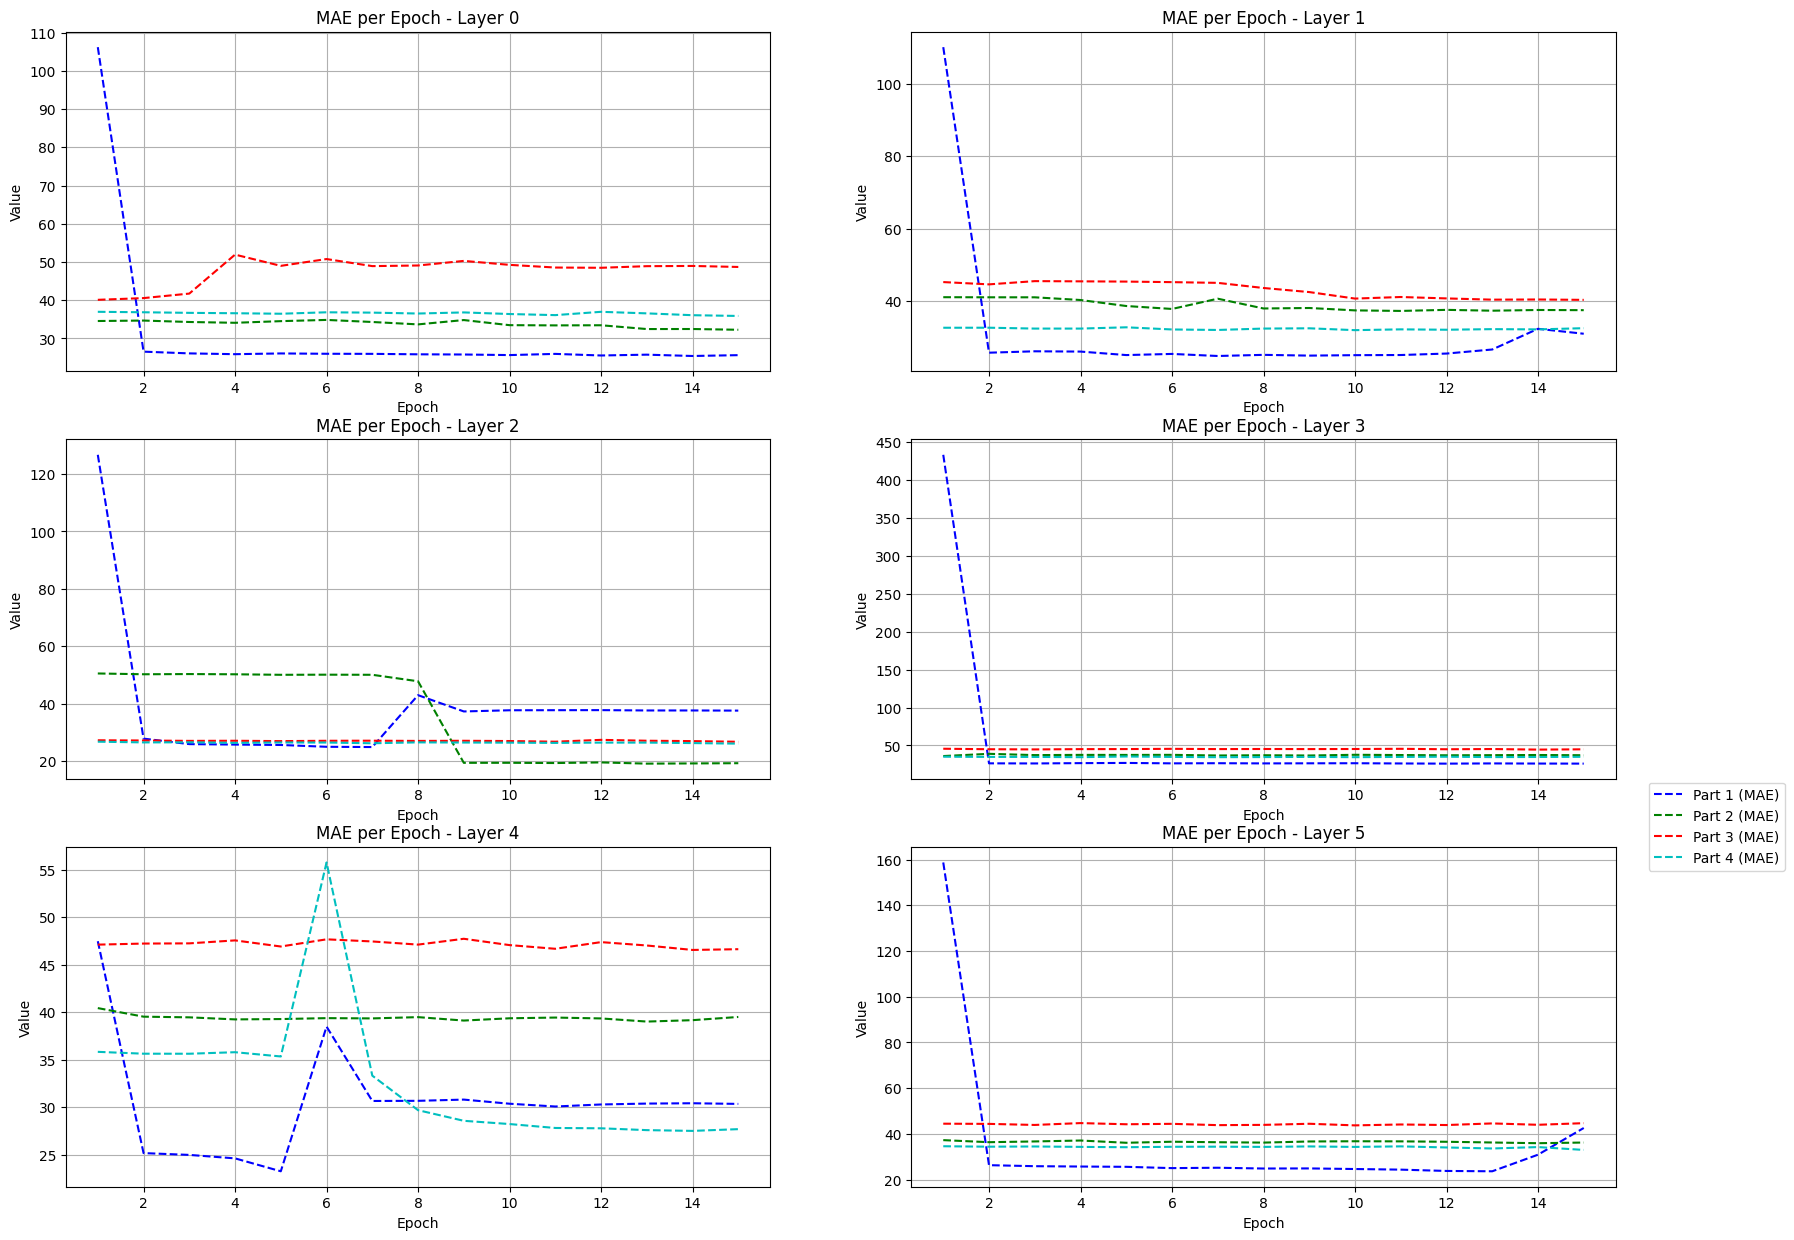

In [39]:
num_filas = 3
num_columnas = 2
full_histories=[full_history_0,full_history_1,full_history_2,full_history_3,full_history_4,full_history_5]
# Crea la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 15))
for i in range(num_filas):
    for j in range(num_columnas):
        index = i * num_columnas + j
        if index < len(full_histories):
            for a in range(len(full_histories[i*2+j])):
                # Extrae los valores de loss y mae de la full_history actual
                mae = full_histories[i*2+j][a][1]                
                # Grafica los valores de mae
                axs[i,j].plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (MAE)', linestyle='dashed', color=colors[a])
                axs[i, j].set_xlabel('Epoch')
                axs[i, j].set_ylabel('Value')
                
                axs[i, j].set_title('MAE per Epoch - Layer {}'.format(index))
                
                axs[i, j].grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,0.91))
            
plt.savefig('mae layered.png',format='png')

# Muestra la figura
plt.show()